<a href="https://colab.research.google.com/github/ap805/RawStockData/blob/master/Copy_of_Github_KaggleStocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/PascoSports/Stocks

#My Code




Import Statements and Getting Raw GitHub Data


In [ ]:
#Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from pandas_datareader.data import DataReader # For reading stock data from yahoo
from datetime import datetime # For time stamps
#Import ML statements
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#Link to Github Raw Data
#Round 1 --> #link2Data = 'https://raw.githubusercontent.com/PascoSports/Stocks/master/No_Date_AAPL_new.csv'
link2Data = "https://raw.githubusercontent.com/ap805/RawStockData/master/SPY%2030min.csv"


#Getting the data from GitHub
activedf_NODATE = pd.read_csv(link2Data, dtype=float,delimiter=',', skiprows=0, float_precision=float)
originaldf_NODATE = pd.read_csv(link2Data, dtype=float,delimiter=',', skiprows=0, float_precision=float)

Adding "shifted close number" column to the activeStock_df dataframe (so we know the answer of tomorrow's quote, use later in ML code) 



In [ ]:
lenny = len(activedf_NODATE)
tomor_close = []

for i in range(lenny-1):
  tomor_close.append(activedf_NODATE["Close"][i+1])

tomor_close.append(117) #random number as a fake substitute for the current day's would be closing price
activedf_NODATE["TomorrowClose"] = tomor_close #adding the shifted close number to df

activedf_NODATE.drop(activedf_NODATE.tail(1).index,inplace=True)
originaldf_NODATE.drop(originaldf_NODATE.tail(1).index,inplace=True)


#Print check
print("active", len(activedf_NODATE))
print(len(originaldf_NODATE))

print("active:", activedf_NODATE.tail())
print(originaldf_NODATE.tail())

active 1313
1313
active:         Open    High  ...  Exp Moving Average 20  TomorrowClose
1308  333.14  333.53  ...                 335.86         331.48
1309  331.70  332.73  ...                 335.45         332.41
1310  331.48  333.13  ...                 335.16         333.62
1311  332.41  334.32  ...                 335.01         334.71
1312  333.60  334.92  ...                 334.98         334.07

[5 rows x 9 columns]
        Open    High  ...  Exp Moving Average 10  Exp Moving Average 20
1308  333.14  333.53  ...                 334.52                 335.86
1309  331.70  332.73  ...                 333.97                 335.45
1310  331.48  333.13  ...                 333.68                 335.16
1311  332.41  334.32  ...                 333.67                 335.01
1312  333.60  334.92  ...                 333.86                 334.98

[5 rows x 8 columns]


Machine Learning Algorithm Application


In [ ]:
#Using Stochastic Gradient Descent
#More on SGD: 
    #https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor.predict
#More on why I chose SGD:
    #https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

#Making the ML Model
SGD_v1 = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3))

#Fitting the Data
SGD_v1.fit(originaldf_NODATE.values, activedf_NODATE['TomorrowClose'].values)

#Adding a "SGD Projected close" column to activeStocks_df
activedf_NODATE["ProjectedCloseViaSGD"] = SGD_v1.predict(originaldf_NODATE.values)

#Print
#originaldf_NODATE
activedf_NODATE

,Open,High,Low,Close,Moving Average 200,Moving Average 50,Exp Moving Average 10,Exp Moving Average 20,TomorrowClose,ProjectedCloseViaSGD
0,282.44,283.04,281.49,281.59,268.14,281.06,283.28,283.36,277.65,282.458646
1,276.48,278.04,275.34,277.65,268.25,281.07,282.26,282.81,276.88,277.726125
2,277.65,277.81,276.00,276.88,268.35,281.08,281.28,282.25,274.18,277.763715
3,276.87,277.07,274.11,274.18,268.43,281.04,279.99,281.48,272.88,276.212402
4,274.18,274.37,272.55,272.88,268.50,280.96,278.70,280.66,273.61,274.256984
...,...,...,...,...,...,...,...,...,...,...
1308,333.14,333.53,331.59,331.70,344.13,337.89,334.52,335.86,331.48,332.752977
1309,331.70,332.73,331.00,331.48,344.10,337.63,333.97,335.45,332.41,332.029055
1310,331.48,333.13,331.13,332.41,344.08,337.38,333.68,335.16,333.62,332.265942
1311,332.41,334.32,332.40,333.62,344.06,337.20,333.67,335.01,334.71,333.270219


In [ ]:
noDate_activeStock_df[0:1].values

array([['115.00', '115.01', '114.86', '114.91', '114.52', '114.83',
        '114.94', '114.86']], dtype=object)

In [ ]:
#Are we correct?
print("---Manual Check---") 

print("Original Data Row:", originaldf_NODATE[0:1].values) #One Row
print(SGD_v1.predict(originaldf_NODATE[0:1].values))
print(activedf_NODATE.values[0][-1])

print(activedf_NODATE.values[0][-1]==SGD_v1.predict(noDate_activeStock_df[0:1].values))

---Manual Check---
Original Data Row: [[282.44 283.04 281.49 281.59 268.14 281.06 283.28 283.36]]
[282.45864599]
282.4586459866774
[False]


Testing Direction


In [ ]:
count = 0
correct_pred = 0
incorrect_pred = 0

for i in range(len(activedf_NODATE.values.tolist())):
  count += 1
  monday_close = activedf_NODATE.values[i][3] #Yesterday's close
  tuesday_real_close = activedf_NODATE.values[i][8] 
  tuesday_projected_close = activedf_NODATE.values[i][9] #Tomorrow's projected close based off model

  if ( tuesday_projected_close > monday_close and tuesday_real_close > monday_close):
    correct_pred += 1
    #print(i, "OK")
  elif ( tuesday_projected_close < monday_close and tuesday_real_close < monday_close):
    correct_pred += 1
    #print(i, "OK")
  else:
    incorrect_pred += 1
    #print(i, "Bad")


print("count:", count)
print("Correct:", correct_pred)
print("InCorrect:", incorrect_pred)
print("Directionally Correct %:", correct_pred/count)
print("Score:",SGD_v1.score(originaldf_NODATE.values, activedf_NODATE['TomorrowClose'].values) )

count: 1313
Correct: 649
InCorrect: 664
Directionally Correct %: 0.49428789032749426
Score: 0.9963753613099502


Graphing the Data

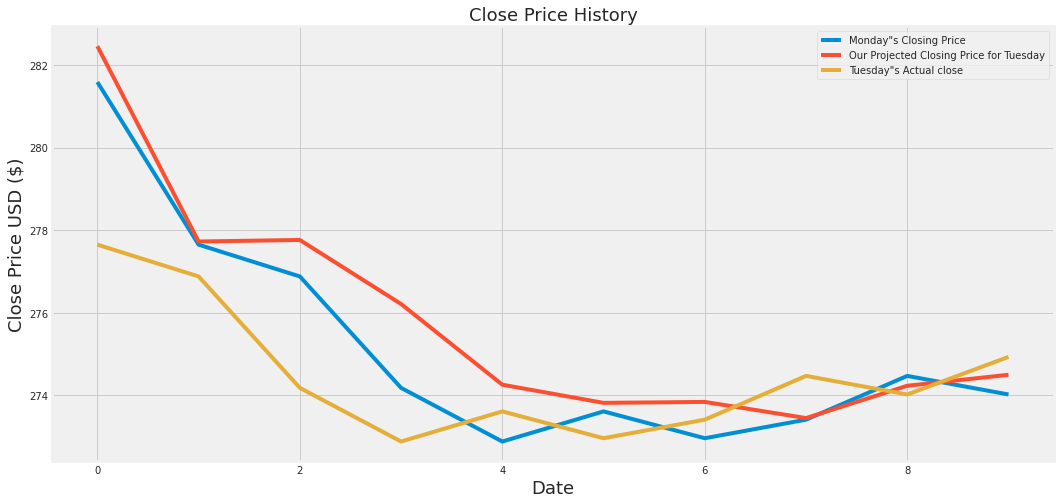

0 WRONG Tues's Proj, 282.46 , didn't correlate with Tues's actual, 277.65  since Mon's Close was 281.59
1 WRONG Tues's Proj, 277.73 , didn't correlate with Tues's actual, 276.88  since Mon's Close was 277.65
2 WRONG Tues's Proj, 277.76 , didn't correlate with Tues's actual, 274.18  since Mon's Close was 276.88
3 WRONG Tues's Proj, 276.21 , didn't correlate with Tues's actual, 272.88  since Mon's Close was 274.18
4 BOTH Tues's Projection, 274.26 , and Tues's actual close, 273.61  was HIGHER than Mon's Close 272.88
5 WRONG Tues's Proj, 273.82 , didn't correlate with Tues's actual, 272.96  since Mon's Close was 273.61
6 BOTH Tues's Projection, 273.84 , and Tues's actual close, 273.41  was HIGHER than Mon's Close 272.96
7 BOTH Tues's Projection, 273.45 , and Tues's actual close, 274.47  was HIGHER than Mon's Close 273.41
8 BOTH Tues's Projection, 274.23 , and Tues's actual close, 274.02  was LOWER than Mon's Close 274.47
9 BOTH Tues's Projection, 274.5 , and Tues's actual close, 274.93  wa

In [ ]:
#Zooming in Variables
start_val = 0
end_val = 10

#Plotting
plt.figure(figsize=(16,8))
plt.plot(activedf_NODATE['Close'][start_val:end_val])
plt.plot(activedf_NODATE["ProjectedCloseViaSGD"][start_val:end_val])
plt.plot(activedf_NODATE["TomorrowClose"][start_val:end_val])

#aesthetic
plt.title('Close Price History', fontsize = 18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend(['Monday"s Closing Price', 'Our Projected Closing Price for Tuesday', 'Tuesday"s Actual close'])
plt.show() #Showing the graphic

#Print check statements
graph_counter = 0
graph_correct = 0
graph_incorrect = 0

for i in range(end_val):
  graph_counter += 1
  monday_close = activedf_NODATE.values[i][3] #Yesterday's close
  tuesday_real_close = activedf_NODATE.values[i][8] 
  tuesday_projected_close = activedf_NODATE.values[i][9] #Tomorrow's projected close based off model

  if ( tuesday_projected_close > monday_close and tuesday_real_close > monday_close):
    graph_correct += 1
    print(i, "BOTH Tues's Projection,", round(tuesday_projected_close,2), ", and Tues's actual close,", round(tuesday_real_close,2), " was HIGHER than Mon's Close", round(monday_close,2))
  elif ( tuesday_projected_close < monday_close and tuesday_real_close < monday_close):
    graph_correct += 1
    print( i, "BOTH Tues's Projection,", round(tuesday_projected_close, 2), ", and Tues's actual close,", round(tuesday_real_close,2), " was LOWER than Mon's Close", round(monday_close,2))
  else:
    graph_incorrect += 1
    print(i, "WRONG Tues's Proj,", round(tuesday_projected_close,2), ", didn't correlate with Tues's actual,", round(tuesday_real_close,2), " since Mon's Close was", round(monday_close,2))

print("\ncount:", graph_counter)
print("Correct:", graph_correct)
print("InCorrect:", graph_incorrect)
print("Directionally Correct %:", graph_correct/graph_counter)

#Train/Test Split Data




In [ ]:
#SAMPLE SGD
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

n_samples, n_features = 10, 5
rng = np.random.RandomState(0)
y = rng.randn(n_samples)
X = rng.randn(n_samples, n_features)
# Always scale the input. The most convenient way is to use a pipeline.
reg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X, y)
y

array([ 1.76405235,  0.40015721,  0.97873798,  2.2408932 ,  1.86755799,
       -0.97727788,  0.95008842, -0.15135721, -0.10321885,  0.4105985 ])

https://www.kaggle.com/faressayah/stock-market-analysis-prediction-using-lstm/notebook#6.-Predicting-the-closing-price-stock-price-of-APPLE-inc:

https://www.linkedin.com/in/fares-sayah/